# Load utils

In [3]:
# Imports
import json
import pandas as pd
from tqdm import tqdm
import logging
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

!pip install prettytable

In [2]:
%run utils/helper_functions.py

# Additional Functions
def calculateMeanVote(row):
    totalVote = 0
    voteCount = 0
    for vote in row:
        try:
            totalVote = totalVote + int(vote['Total points awarded'])
            voteCount = voteCount + 1
        except KeyError:
            continue
    if voteCount > 0:
        return round(totalVote / voteCount, 1)
    else:
        return 0

# Load Debate.org Dataset

In [6]:
with open("../data/debateorg/debateorg.json", "r") as d:
    debates_dict = json.load(d)
with open("../data/debateorg/users.json", "r") as u:
      users_dict = json.load(u)

In [7]:
# Extract the debate data and write in a pandas DataFrame
def extract_data(debates_data: dict, users_data: dict) -> pd.DataFrame:
    """Extract and combines debates and user data into a single dataframe. Return the dataframe.
    Currently, only the birthday, education, gender and political orientation are extracted and
    returned as user-defining features.
    Arguments:
    debates_data -- Dictionary containing the debates data.
    users_data -- Dictionary containing the users and their properties.
    """
    extracted_data = []
    # The user data that should be extracted
    properties_of_interest = ["birthday", "ethnicity", "gender", "political_ideology", "education", 
                              "interested", "income", "looking", "party", "relationship", "win_ratio", 
                              "religious_ideology", "number_of_all_debates", "big_issues_dict"]

    for key, debate in tqdm(debates_data.items()):
        # Sometimes, the users of the debate didn't exist anymore at the time
        # the data was collected.
        try:
            category = debate["category"]
        except KeyError:
            category = None
            
        try:
            title = debate["title"]
        except KeyError:
            title = None
        
        try:
            date = debate["start_date"]
        except KeyError:
            date = None
        
        try:
            user1 = users_data[debate["participant_1_name"]]
        except KeyError:
            user1 = None

        try:
            user2 = users_data[debate["participant_2_name"]]
        except KeyError:
            user2 = None

        # If both users do not exist, skip this debate
        if not user1 and not user2:
            logging.debug("Both users are absent from debate data. Skipping.")
            continue

        # For each round in this debate...
        for debate_round in debate["rounds"]:
            # For each argument in this round...
            for argument in debate_round:
                arguing_user = (
                    user1 if argument["side"] == debate["participant_1_position"] else user2)
                
                arguing_user_name = (
                    debate["participant_1_name"] if argument["side"] == debate["participant_1_position"] else debate["participant_2_name"])

                # Skip this argument if arguing user does not exist in the dta
                if not arguing_user:
                    continue
                    
                # Filtering for votes
                votes = []
                for vote in debate['votes']:
                    votes.append(vote['votes_map'][arguing_user_name])

                # Filtering for relevant properties
                properties = {
                    key: value
                    for key, value in arguing_user.items() if key in properties_of_interest}

                # Save the text and find the political ideology of the user.
                extracted_data.append({
                    "argument": argument["text"],
                    "title": title,
                    "category": category,
                    "date": date,
                    **properties,
                    "votes": votes})

    return pd.DataFrame(columns=["argument", "title", "category", "date", *properties_of_interest, "votes"], data=extracted_data)

In [8]:
df_debates = extract_data(debates_dict, users_dict)

100%|██████████████████████████████████████████████████████████████████████████| 78376/78376 [00:07<00:00, 9945.52it/s]


In [9]:
print('Length of debate data set: '+str(len(df_debates)))

Length of debate data set: 510771


In [10]:
# Extract the data and write in a pandas DataFrame
def extract_user_data(users_data: dict) -> pd.DataFrame:
    extracted_data = []
    # The user data that should be extracted
    properties_of_interest = ["birthday", "ethnicity", "gender", "political_ideology", "education", 
                              "interested", "income", "looking", "party", "relationship", "win_ratio", 
                              "religious_ideology", "number_of_all_debates", "big_issues_dict"]

    for key, user in tqdm(users_data.items()):

        # Filtering for relevant properties
        properties = {
            key: value
            for key, value in user.items() if key in properties_of_interest}

        # Save the text and find the political ideology of the user.
        extracted_data.append({
            "user": key,
            **properties})

    return pd.DataFrame(columns=["user", *properties_of_interest], data=extracted_data)

In [11]:
df_users = extract_user_data(users_dict)

100%|█████████████████████████████████████████████████████████████████████████| 45348/45348 [00:00<00:00, 76991.42it/s]


In [12]:
print('Length of user data set: '+str(len(df_users)))

Length of user data set: 45348


# Basic Statistics

## Debates

In [13]:
print('Number of different debates: ' + str(len(debates_dict))) 
print('Number of arguments: ' + str(len(df_debates)))
print('Number of users: ' + str(len(users_dict)))
print('All Attributes: ' + str(df_debates.columns.tolist()))

Number of different debates: 78376
Number of arguments: 510771
Number of users: 45348
All Attributes: ['argument', 'title', 'category', 'date', 'birthday', 'ethnicity', 'gender', 'political_ideology', 'education', 'interested', 'income', 'looking', 'party', 'relationship', 'win_ratio', 'religious_ideology', 'number_of_all_debates', 'big_issues_dict', 'votes']


In [16]:
def printAllBasicStatisticsArgument():
    
    t = PrettyTable(['Attribute', 'Mean', 'Min', 'Max', 'Median', 'Mode'])
    
    # Date
    df_debates["date"] = pd.to_datetime(df_debates["date"])
    df_debates['year'] = df_debates.apply(lambda row: row['date'].year, axis = 1)
    
    t.add_row(['Debate Start', df_debates["year"].mean(), df_debates["year"].min(), 
               df_debates["year"].max(), df_debates["year"].median(), df_debates["year"].mode()[0]])
    
    # Category
    t.add_row(['Category', '', '', '', '', df_debates['category'].mode()[0]])
    
    # Argumentlength
    df_debates['argument_length'] = df_debates.apply(lambda row: len(row['argument'].split()), axis = 1)
    t.add_row(['Argument Length', df_debates["argument_length"].mean(), df_debates["argument_length"].min(), 
               df_debates["argument_length"].max(), df_debates["argument_length"].median(), 
               df_debates["argument_length"].mode()[0]])
    
    # votes
    df_debates["mean_vote"] = df_debates.apply(lambda row: calculateMeanVote(row['votes']), axis = 1)
        
    t.add_row(['Mean vote', df_debates["mean_vote"].mean(), df_debates["mean_vote"].min(), 
               df_debates["mean_vote"].max(), df_debates["mean_vote"].median(), df_debates["mean_vote"].mode()[0]])
    
    
    variables = ['year', 'mean_vote', 'category', 'argument_length']
    colors = ['skyblue', 'olive', 'gold', 'teal']
        
    print(t)

    fig=plt.figure(figsize=(10, 5))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(2,2,i+1)
        g = sns.histplot(data=df_debates, x=var_name, color=np.random.rand(3,), bins=10, ax=ax)
        plt.xticks(rotation=90)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()
    

+-----------------+--------------------+------+-------+--------+----------+
|    Attribute    |        Mean        | Min  |  Max  | Median |   Mode   |
+-----------------+--------------------+------+-------+--------+----------+
|   Debate Start  | 2013.785794416676  | 2007 |  2018 | 2014.0 |   2014   |
|     Category    |                    |      |       |        | Politics |
| Argument Length | 219.51759203243725 |  0   | 16174 |  52.0  |    1     |
|    Mean vote    | 1.253838412909102  | 0.0  |  7.0  |  0.0   |   0.0    |
+-----------------+--------------------+------+-------+--------+----------+


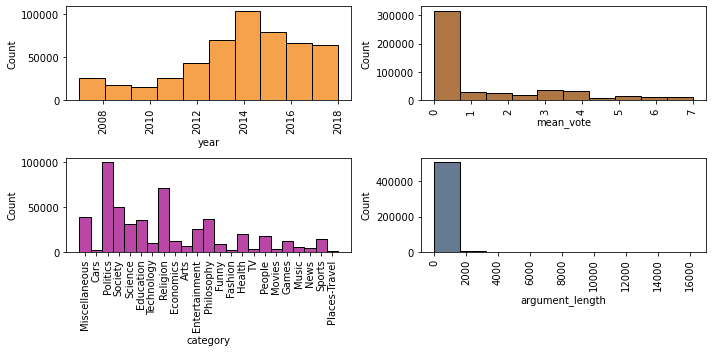

In [17]:
printAllBasicStatisticsArgument()

## Users

In [18]:
print('All user attributes: ' + str(df_users.columns.tolist()))

All user attributes: ['user', 'birthday', 'ethnicity', 'gender', 'political_ideology', 'education', 'interested', 'income', 'looking', 'party', 'relationship', 'win_ratio', 'religious_ideology', 'number_of_all_debates', 'big_issues_dict']


### Birthday / Age

+-----------+---------+-------------------+--------+-----+-----+
| Attribute | Missing |        Mean       | Median | Min | Max |
+-----------+---------+-------------------+--------+-----+-----+
|    Age    |  44682  | 31.90990990990991 |  26.0  |  17 | 122 |
+-----------+---------+-------------------+--------+-----+-----+


Text(0.5, 0.98, 'Age')

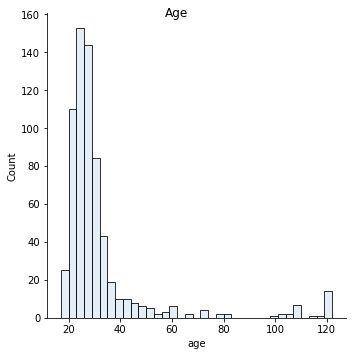

In [21]:
# Subset of non empty values
bday = df_users[df_users['birthday'] != '- Private -'] 
bday['birthday'] = pd.to_datetime(bday['birthday'])
bday['birthYear'] = bday.apply(lambda row: row['birthday'].year, axis = 1)
bday['age'] = bday.apply(lambda row: (2021 - row['birthYear']), axis = 1)

# Calculate Statistics
age_missing = len(df_users[df_users['birthday'] == '- Private -'])
age_mean = bday['age'].mean()
age_median = bday['age'].median()
age_min = bday['age'].min()
age_max = bday['age'].max()

# Print basic statistics
t_birthday = PrettyTable(['Attribute', 'Missing', 'Mean', 'Median', 'Min', 'Max'])

t_birthday.add_row(['Age', age_missing, age_mean, age_median, age_min, age_max])

print(t_birthday)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

ageHist = sns.displot(bday, 
            x="age",
           binwidth=3)

ageHist.fig.suptitle("Age")

### Gender

In [22]:
df_users['gender'].value_counts()

Prefer not to say     28780
Male                  11234
Female                 5216
Genderqueer              39
Agender                  26
Transgender Female       16
Transgender Male         14
Bigender                 14
Androgyne                 9
Name: gender, dtype: int64

+-----------+---------+---------------+
| Attribute | Missing |      Mode     |
+-----------+---------+---------------+
|   Gender  |  28780  |   0    Male   |
|           |         | dtype: object |
+-----------+---------+---------------+


Text(0.5, 0.98, 'Gender')

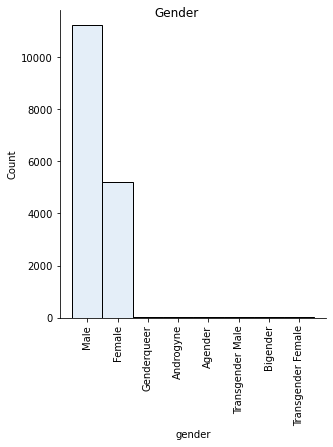

In [23]:
# Subset of non empty values
gender = df_users[df_users['gender'] != 'Prefer not to say'] 

# Calculate Statistics
gender_missing = len(df_users[df_users['gender'] == 'Prefer not to say'])
gender_max = gender['gender'].mode()

# Print basic statistics
t_gender = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_gender.add_row(['Gender', gender_missing, gender_max])

print(t_gender)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

genderHist = sns.displot(gender, 
            x="gender",
           binwidth=3)
plt.xticks(rotation=90)
genderHist.fig.suptitle("Gender")

### Ethnicity

+-----------+---------+---------------+
| Attribute | Missing |      Mode     |
+-----------+---------+---------------+
| Ethnicity |  30118  |   0    White  |
|           |         | dtype: object |
+-----------+---------+---------------+


Text(0.5, 0.98, 'Ethnicity')

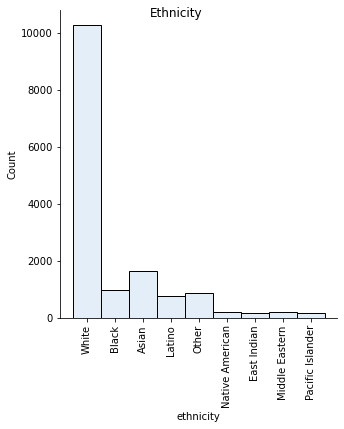

In [24]:
# Subset of non empty values
ethnicity = df_users[df_users['ethnicity'] != 'Not Saying']

# Calculate Statistics
ethnicity_missing = len(df_users[df_users['ethnicity'] == 'Not Saying'])
ethnicity_max = ethnicity['ethnicity'].mode()

# Print basic statistics
t_ethnicity = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_ethnicity.add_row(['Ethnicity', ethnicity_missing, ethnicity_max])

print(t_ethnicity)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

ethnicityHist = sns.displot(ethnicity, 
            x="ethnicity",
           binwidth=3)
plt.xticks(rotation=90)
ethnicityHist.fig.suptitle("Ethnicity")

### Pol. Ideology

+--------------------+---------+-------------------+
|     Attribute      | Missing |        Mode       |
+--------------------+---------+-------------------+
| Political Ideology |  32806  | 0    Conservative |
|                    |         |   dtype: object   |
+--------------------+---------+-------------------+


Text(0.5, 0.98, 'Pol. Ideology')

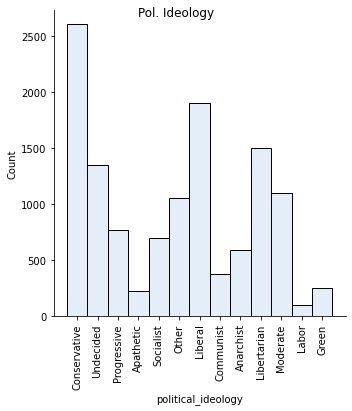

In [25]:
# Subset of non empty values
pol_ideol = df_users[df_users['political_ideology'] != 'Not Saying']

# Calculate Statistics
pol_ideol_missing = len(df_users[df_users['political_ideology'] == 'Not Saying'])
pol_ideol_max = pol_ideol['political_ideology'].mode()

# Print basic statistics
t_pol_ideology = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_pol_ideology.add_row(['Political Ideology', pol_ideol_missing, pol_ideol_max])

print(t_pol_ideology)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

pol_ideolHist = sns.displot(pol_ideol, 
            x="political_ideology",
           binwidth=3)
plt.xticks(rotation=90)
pol_ideolHist.fig.suptitle("Pol. Ideology")

### Party

+-----------+---------+-----------------------+
| Attribute | Missing |          Mode         |
+-----------+---------+-----------------------+
|   Party   |  33910  | 0    Republican Party |
|           |         |     dtype: object     |
+-----------+---------+-----------------------+


Text(0.5, 0.98, 'Party')

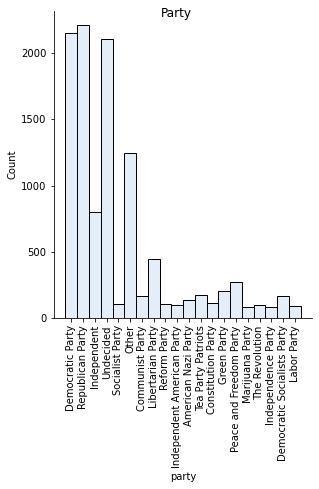

In [26]:
# Subset of non empty values
party = df_users[df_users['party'] != 'Not Saying']

# Calculate Statistics
party_missing = len(df_users[df_users['party'] == 'Not Saying'])
party_max = party['party'].mode()


# Print basic statistics
t_party = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_party.add_row(['Party', party_missing, party_max])

print(t_party)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

largestParties = party['party'].value_counts()[:20].index.tolist()
subsetParties = df_users[df_users['party'].isin(largestParties)]


partyHist = sns.displot(subsetParties, 
            x="party",
           binwidth=3)
plt.xticks(rotation=90)
partyHist.fig.suptitle("Party")

### Education

+-----------+---------+------------------+
| Attribute | Missing |       Mode       |
+-----------+---------+------------------+
| Education |  34596  | 0    High School |
|           |         |  dtype: object   |
+-----------+---------+------------------+


Text(0.5, 0.98, 'Education')

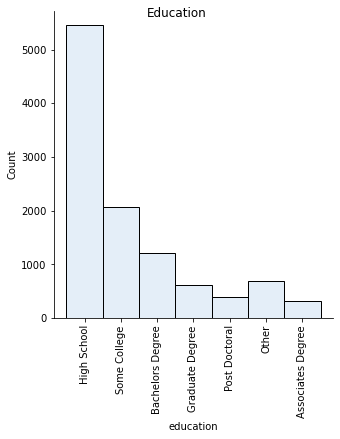

In [27]:
# Subset of non empty values
education = df_users[df_users['education'] != 'Not Saying']

# Calculate Statistics
education_missing = len(df_users[df_users['education'] == 'Not Saying'])
education_max = education['education'].mode()

# Print basic statistics
t_education = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_education.add_row(['Education', education_missing, education_max])

print(t_education)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

educationHist = sns.displot(education, 
            x="education",
           binwidth=3)
plt.xticks(rotation=90)
educationHist.fig.suptitle("Education")

### Interested

+------------+---------+----------------+
| Attribute  | Missing |      Mode      |
+------------+---------+----------------+
| Interested |   1358  | 0    No Answer |
|            |         | dtype: object  |
+------------+---------+----------------+


Text(0.5, 0.98, 'Interested')

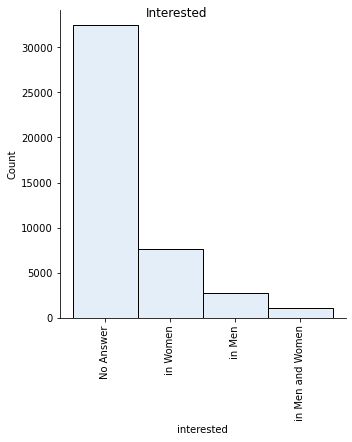

In [28]:
# Subset of non empty values
interested = df_users[(df_users['interested'] != 'Not Saying') & (df_users['interested'] != '- Private -')]

# Calculate Statistics
interested_missing = len(df_users[(df_users['interested'] == 'Not Saying') | (df_users['interested'] == '- Private -')])
interested_max = interested['interested'].mode()

# Print basic statistics
t_interested = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_interested.add_row(['Interested', interested_missing, interested_max])

print(t_interested)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

interestedHist = sns.displot(interested, 
            x="interested",
           binwidth=3)
plt.xticks(rotation=90)
interestedHist.fig.suptitle("Interested")

### Looking

+-----------+---------+-----------------+
| Attribute | Missing |       Mode      |
+-----------+---------+-----------------+
|  Looking  |   1225  | 0    Friendship |
|           |         |  dtype: object  |
+-----------+---------+-----------------+


Text(0.5, 0.98, 'Looking')

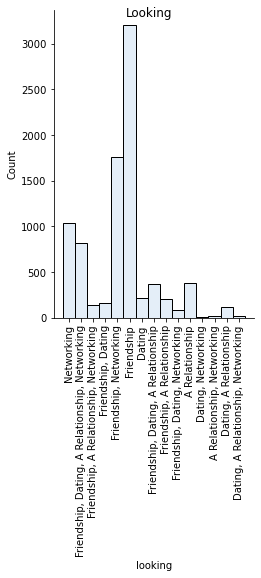

In [29]:
# Subset of non empty values
looking = df_users[(df_users['looking'] != 'No Answer') & (df_users['looking'] != '- Private -')]

# Calculate Statistics
looking_missing = len(df_users[(df_users['looking'] == 'Not Saying') | (df_users['looking'] == '- Private -')])
looking_max = looking['looking'].mode()

# Print basic statistics
t_looking = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_looking.add_row(['Looking', looking_missing, looking_max])

print(t_looking)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

lookingHist = sns.displot(looking, 
            x="looking",
           binwidth=3)
plt.xticks(rotation=90)
lookingHist.fig.suptitle("Looking")

### Income

+-----------+---------+-----------------+
| Attribute | Missing |       Mode      |
+-----------+---------+-----------------+
|   Income  |  39751  | 0    Not Saying |
|           |         |  dtype: object  |
+-----------+---------+-----------------+


Text(0.5, 0.98, 'Income')

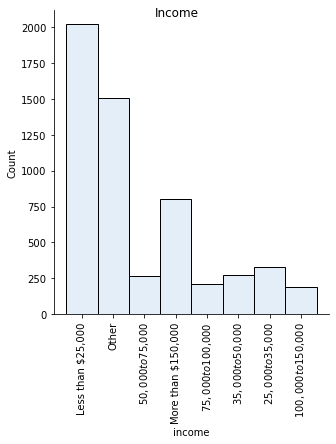

In [34]:
# Subset of non empty values
income = df_users[(df_users['income'] != 'Not Saying') & (df_users['income'] != '- Private -')]

# Calculate Statistics
income_missing = len(df_users[(df_users['income'] == 'Not Saying') | (df_users['income'] == '- Private -')])
income_max = looking['income'].mode()

# Print basic statistics
t_income = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_income.add_row(['Income', income_missing, income_max])

print(t_income)

# Create plot
sns.set_palette(sns.color_palette("Blues"))

incomeHist = sns.displot(income, 
            x="income",
           binwidth=3)
plt.xticks(rotation=90)
incomeHist.fig.suptitle("Income")

### Religious Ideology

In [31]:
def cleanReligiousIdeology(row):
    if 'Hindu' in row['religious_ideology']:
        return 'Hindu'
    elif 'Christian' in row['religious_ideology']:
        return 'Christian'
    elif 'Buddhist' in row['religious_ideology']:
        return 'Buddhist'   
    elif 'Jewish' in row['religious_ideology']:
        return 'Jewish'   
    elif 'Muslim' in row['religious_ideology']:
        return 'Islamic' 
    else:
        return row['religious_ideology']

+--------------------+---------+-----------------+
|     Attribute      | Missing |       Mode      |
+--------------------+---------+-----------------+
| Religious Ideology |  29961  | 0    Not Saying |
|                    |         |  dtype: object  |
+--------------------+---------+-----------------+


Text(0.5, 0.98, 'Religious Ideology')

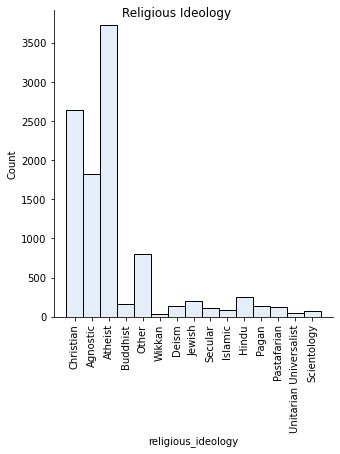

In [35]:
# Subset of non empty values
rel_ideo = df_users[(df_users['religious_ideology'] != 'Not Saying')]

rel_ideo['religious_ideology'] = rel_ideo.apply(lambda row: cleanReligiousIdeology(row), axis = 1)

# Calculate Statistics
rel_ideo_missing = len(df_users[(df_users['religious_ideology'] == 'Not Saying')])
rel_ideo_max = looking['income'].mode()

# Print basic statistics
t_rel_ideo = PrettyTable(['Attribute', 'Missing', 'Mode'])

t_rel_ideo.add_row(['Religious Ideology', rel_ideo_missing, rel_ideo_max])

print(t_rel_ideo)

# Create plot
sns.set_palette(sns.color_palette("Blues"))
largestReligions = rel_ideo['religious_ideology'].value_counts()[:15].index.tolist()
subsetReligions = df_users[df_users['religious_ideology'].isin(largestReligions)]


# Only plot largest
rel_ideoHist = sns.displot(subsetReligions, 
            x="religious_ideology",
           binwidth=3)
plt.xticks(rotation=90)
rel_ideoHist.fig.suptitle("Religious Ideology")


### Create Table

In [37]:
t = PrettyTable(['Attribute', 'Missing #', 'Missing %', 'Mean', 'Min', 'Max', 'Median', '3 - largest'])
    
# age
t.add_row(['Age', age_missing, round(age_missing / len(df_users), 2), round(age_mean, 2), age_min, 
           age_max, age_median, ''])

# ethnicity
t.add_row(['Ethincity', '', round(ethnicity_missing / len(df_users),2), '', 
           '', '', ethnicity_max[0], ethnicity['ethnicity'].value_counts()[:3].index.tolist()])

# gender
t.add_row(['Gender', gender_missing, round(gender_missing / len(df_users), 2), '', '', 
           '', gender_max[0], gender['gender'].value_counts()[:3].index.tolist()])

# Pol. Ideology
t.add_row(['Pol. Ideol.', '', round(pol_ideol_missing / len(df_users),2), '', 
           '', '', pol_ideol_max[0], pol_ideol['political_ideology'].value_counts()[:3].index.tolist()])

# Education
t.add_row(['Education', '', round(education_missing / len(df_users),2), '', 
           '', '', education_max[0], education['education'].value_counts()[:3].index.tolist()])

# Party
t.add_row(['Party', '', round(party_missing / len(df_users),2), '', 
           '', '', party_max[0], party['party'].value_counts()[:3].index.tolist()])

# Interested
t.add_row(['Interested', '', round(interested_missing / len(df_users),2), '', 
           '', '', interested_max[0], interested['interested'].value_counts()[:3].index.tolist()])
print(t)
    

+-------------+-----------+-----------+-------+-----+-----+------------------+-------------------------------------------------------+
|  Attribute  | Missing # | Missing % |  Mean | Min | Max |      Median      |                      3 - largest                      |
+-------------+-----------+-----------+-------+-----+-----+------------------+-------------------------------------------------------+
|     Age     |   44682   |    0.99   | 31.91 |  17 | 122 |       26.0       |                                                       |
|  Ethincity  |           |    0.66   |       |     |     |      White       |              ['White', 'Asian', 'Black']              |
|    Gender   |   28780   |    0.63   |       |     |     |       Male       |           ['Male', 'Female', 'Genderqueer']           |
| Pol. Ideol. |           |    0.72   |       |     |     |   Conservative   |       ['Conservative', 'Liberal', 'Libertarian']      |
|  Education  |           |    0.76   |       |     |  

### Evaluation of Big issues

In [48]:
big_issues_list = []
for entry in df_users['big_issues_dict']:
    big_issues_list.append(entry)
    
big_issues_df = pd.DataFrame(big_issues_list)
big_issues_df

,Abortion,Affirmative Action,Animal Rights,Barack Obama,Border Fence,Capitalism,Civil Unions,Death Penalty,Drug Legalization,Electoral College,...,Social Programs,Social Security,Socialism,Stimulus Spending,Term Limits,Torture,United Nations,War in Afghanistan,War on Terror,Welfare
0,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,...,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S
1,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,...,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S
2,Pro,N/O,Pro,Pro,N/O,Pro,N/O,Und,Und,Und,...,Pro,Pro,Con,Pro,Pro,Con,Pro,Pro,Pro,Pro
3,Pro,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,...,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S
4,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,...,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45343,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,...,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S
45344,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,...,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S
45345,Pro,Pro,Con,Und,Con,Pro,Pro,Und,Pro,Pro,...,Pro,Pro,Pro,Con,Pro,N/O,Pro,Con,Con,N/O
45346,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,...,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S,N/S


In [54]:
big_issues_df['Abortion'].value_counts()

N/S    29420
Pro     6877
Con     6798
Und     1215
N/O     1038
Name: Abortion, dtype: int64

In [56]:
# Calculate basic statistics
big_issues_topics = big_issues_df.columns.values.tolist()

t = PrettyTable(['Topic', 'PRO', 'CON', 'N/A'])

for topic in big_issues_topics:
    t.add_row([topic, 
               len(big_issues_df[big_issues_df[topic] =='Pro']), 
               len(big_issues_df[big_issues_df[topic] =='Con']),
               len(big_issues_df[(big_issues_df[topic] !='Pro') & (big_issues_df[topic] !='Con')])])
    
print(t)    

+---------------------------+------+------+-------+
|           Topic           | PRO  | CON  |  N/A  |
+---------------------------+------+------+-------+
|          Abortion         | 6877 | 6798 | 31673 |
|     Affirmative Action    | 2614 | 4651 | 38083 |
|       Animal Rights       | 6568 | 1294 | 37486 |
|        Barack Obama       | 2910 | 3984 | 38454 |
|        Border Fence       | 4885 | 4418 | 36045 |
|         Capitalism        | 4600 | 1763 | 38985 |
|        Civil Unions       | 5563 | 2140 | 37645 |
|       Death Penalty       | 6550 | 6252 | 32546 |
|     Drug Legalization     | 6207 | 5802 | 33339 |
|     Electoral College     | 1967 | 3129 | 40252 |
|  Environmental Protection | 9409 | 1247 | 34692 |
|         Estate Tax        | 2277 | 3916 | 39155 |
|       European Union      | 2305 | 1569 | 41474 |
|         Euthanasia        | 5011 | 2307 | 38030 |
|      Federal Reserve      | 1397 | 1675 | 42276 |
|          Flat Tax         | 2739 | 3329 | 39280 |
|         Fr

##  User statistics relative to arguments

### Gender

Text(0.5, 0.98, 'Gender')

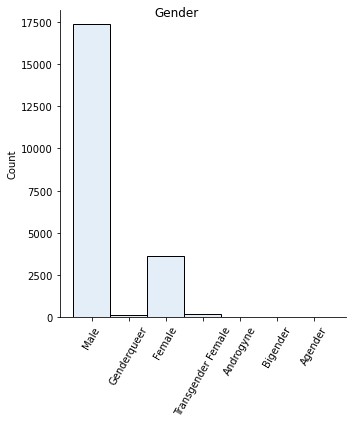

In [44]:
# Only keep records that contain a birthday
genderSubset = df_debates[(df_debates['gender'] != 'Prefer not to say') & (df_debates['birthday'] != '- Private -')]

genderHist = sns.displot(genderSubset, 
            x="gender",
           binwidth=3)

genderHist.set_xticklabels(rotation=60)

genderHist.set(xlabel='')

genderHist.fig.suptitle("Gender")

### Birthday

Text(0.5, 0.98, 'Birth Year')

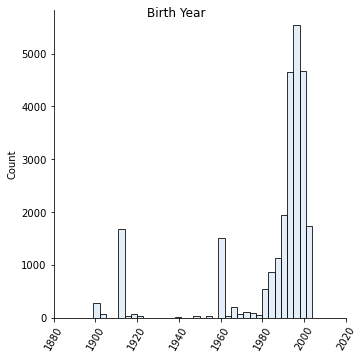

In [43]:
# Only keep records that contain a birthday
birthdaySubset = df_debates[(df_debates['birthday'] != 'Prefer not to say') & (df_debates['birthday'] != '- Private -')]

birthdaySubset['birthday'] = birthdaySubset['birthday'] = pd.to_datetime(birthdaySubset['birthday'])

# Calculate year of birth
birthdaySubset['birthYear'] = birthdaySubset.apply(lambda row: row['birthday'].year, axis = 1)

# Calculate age
birthdaySubset['age'] = birthdaySubset.apply(lambda row: (2021 - row['birthYear']), axis = 1)

birthdayHist = sns.displot(birthdaySubset, 
            x="birthYear",
           binwidth=3)

birthdayHist.set_xticklabels(rotation=60)

birthdayHist.set(xlabel='')

birthdayHist.fig.suptitle("Birth Year")

### Education

Text(0.5, 0.98, 'Education')

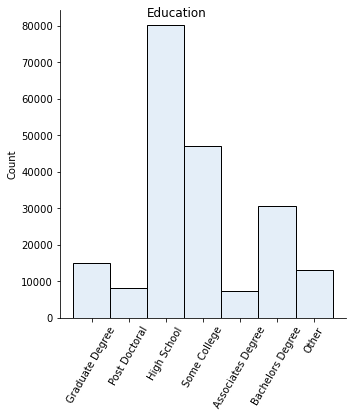

In [39]:
# Only keep records that contain an education
educationSubset = df_debates[df_debates['education'] != 'Not Saying']

sns.set_palette(sns.color_palette("Blues"))

educationHist = sns.displot(educationSubset, 
            x="education",
           binwidth=3)

educationHist.set_xticklabels(rotation=60)

educationHist.set(xlabel='')

educationHist.fig.suptitle("Education")

### Ethnicity

Text(0.5, 0.98, 'Ethnicity')

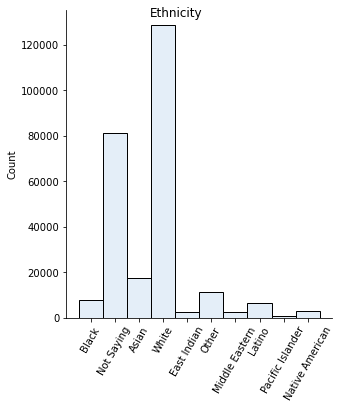

In [45]:
# Only keep records that contain a birthday
ethnicitySubset = df_debates[(df_debates['gender'] != 'Prefer not to say') & (df_debates['ethnicity'] != '- Private -')]

ethnicityHist = sns.displot(ethnicitySubset, 
            x="ethnicity",
           binwidth=3)

ethnicityHist.set_xticklabels(rotation=60)

ethnicityHist.set(xlabel='')

ethnicityHist.fig.suptitle("Ethnicity")